<>:21: SyntaxWarning: invalid escape sequence '\$'
<>:21: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipykernel_893499/4081728824.py:21: SyntaxWarning: invalid escape sequence '\$'
  df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)


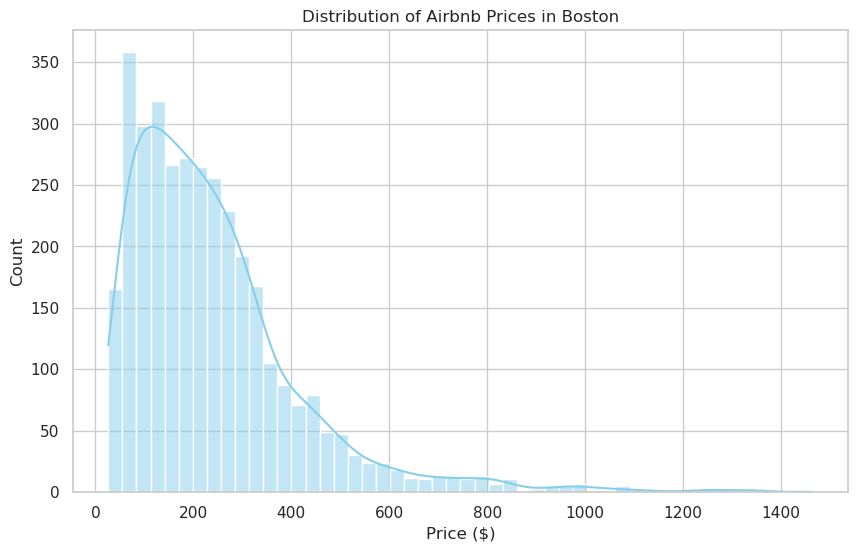

/tmp/ipykernel_893499/4081728824.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='price', y='neighbourhood', data=df, order=order, palette='viridis')


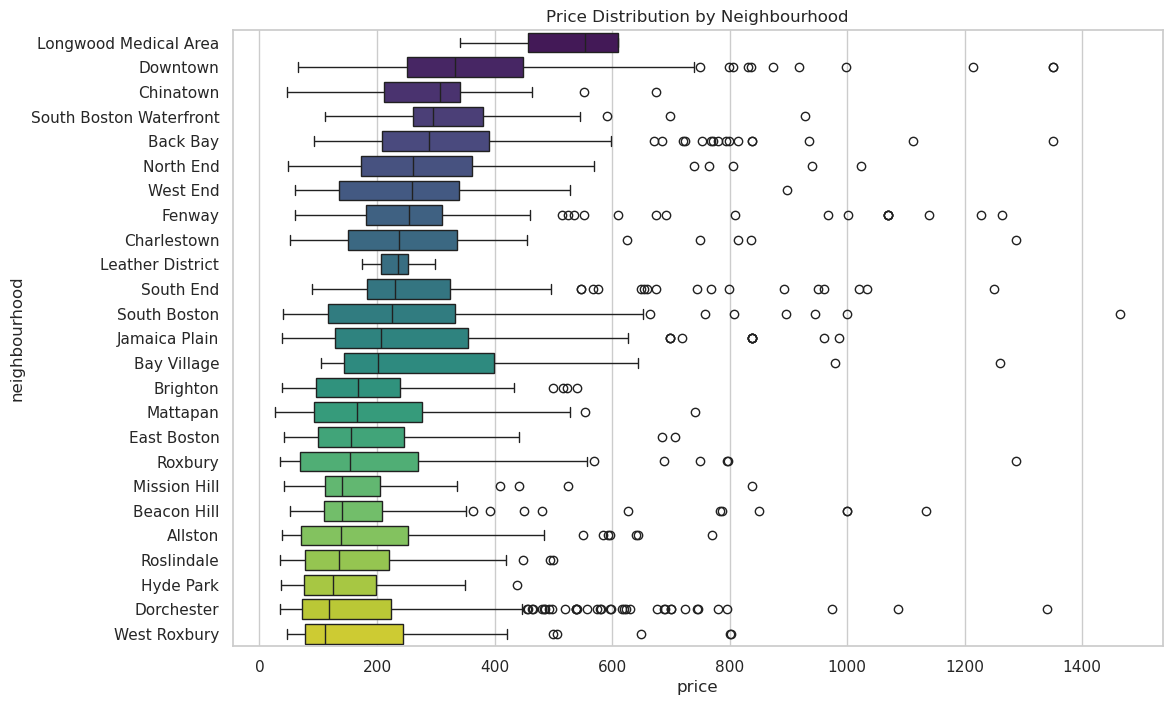

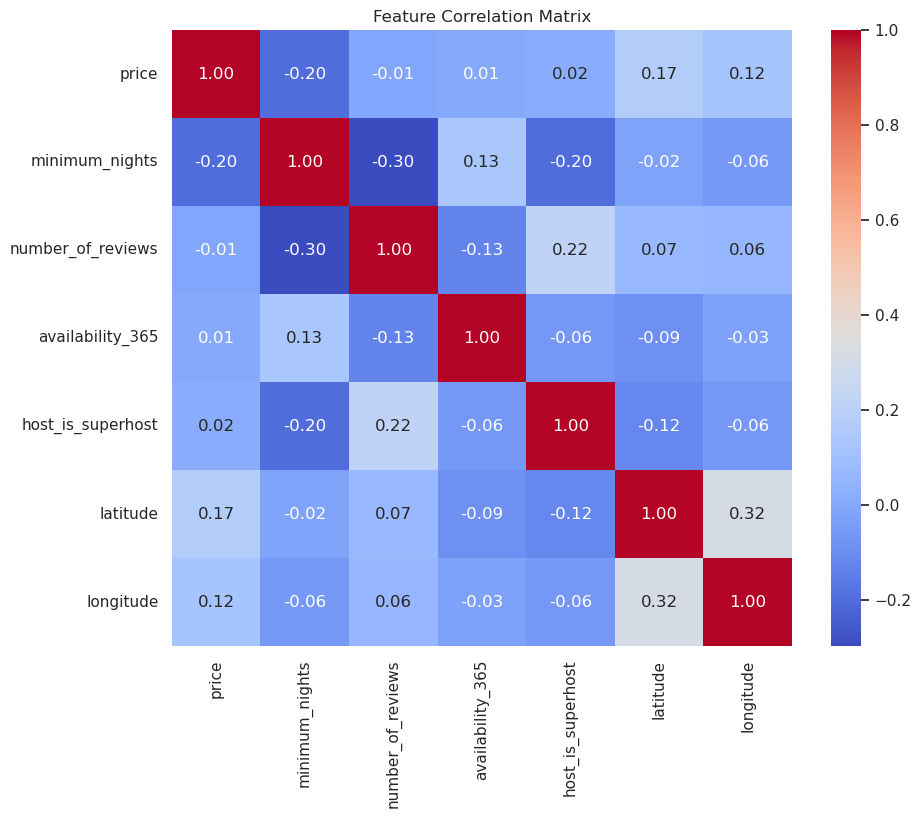

--- Linear Regression Results ---
RMSE: $139.54
R-squared: 0.3107
--- Random Forest Results ---
RMSE: $126.77
R-squared: 0.4310


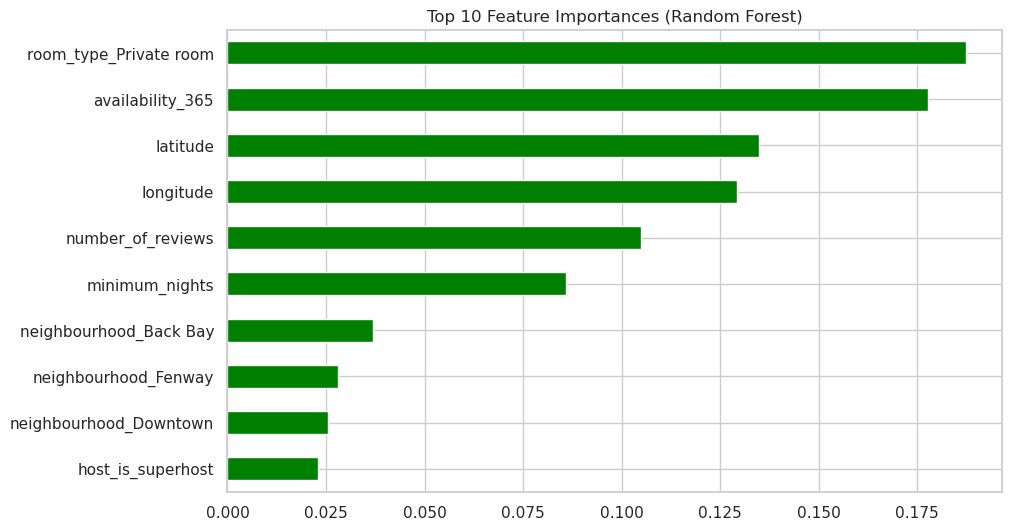

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# 1. DATA LOADING & CLEANING 
url = "https://data.insideairbnb.com/united-states/ma/boston/2025-09-23/data/listings.csv.gz"
df = pd.read_csv(url)

# Keep selected columns
cols = ['price', 'neighbourhood_cleansed', 'room_type', 'minimum_nights', 
        'number_of_reviews', 'availability_365', 'host_is_superhost', 'latitude', 'longitude']
df = df[cols].copy()

# Clean price
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
df.dropna(subset=['price'], inplace=True)
df = df[df['price'] < 1500] # Remove extreme outliers for better visualization

# Handle missing/categorical
df['host_is_superhost'] = df['host_is_superhost'].fillna('f').map({'t': 1, 'f': 0})
df.rename(columns={'neighbourhood_cleansed': 'neighbourhood'}, inplace=True)

#  2. EDA & VISUALIZATIONS (Save these to 'graph' folder) 
# Set style
sns.set(style="whitegrid")

# Graph A: Price Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Airbnb Prices in Boston')
plt.xlabel('Price ($)')
plt.savefig('price_distribution.png') # Save for report
plt.show()


# Graph B: Price by Neighbourhood
plt.figure(figsize=(12, 8))
order = df.groupby('neighbourhood')['price'].median().sort_values(ascending=False).index
sns.boxplot(x='price', y='neighbourhood', data=df, order=order, palette='viridis')
plt.title('Price Distribution by Neighbourhood')
plt.savefig('price_by_neighborhood.png') # Save for report
plt.show()

# Graph C: Correlation Heatmap
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.savefig('correlation_matrix.png') # Save for report
plt.show()

#  3. MODELING 
# Encode categorical variables for modeling
df_model = pd.get_dummies(df, columns=['neighbourhood', 'room_type'], drop_first=True)

X = df_model.drop('price', axis=1)
y = df_model['price']

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale Data (Important for Linear Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model 1: Multiple Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

# Model 2: Random Forest Regression
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train) 
y_pred_rf = rf.predict(X_test)

# --- 4. EVALUATION METRICS ---
def evaluate(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"--- {name} Results ---")
    print(f"RMSE: ${rmse:.2f}")
    print(f"R-squared: {r2:.4f}")

evaluate("Linear Regression", y_test, y_pred_lr)
evaluate("Random Forest", y_test, y_pred_rf)

# Feature Importance (Random Forest)
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
importances.plot(kind='barh', color='green')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.gca().invert_yaxis()
plt.savefig('feature_importance.png')
plt.show()